<a href="https://colab.research.google.com/github/damido31/colabcopys/blob/main/Case_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%run "/content/drive/MyDrive/Colab Notebooks/autograd_lib.ipynb"
%run "/content/drive/MyDrive/Colab Notebooks/problems.ipynb"
# %run "/content/drive/MyDrive/Colab Notebooks/topo_physics.ipynb"
from matplotlib import pyplot as plt
from IPython import display
import xarray as xr

In [ ]:
def get_stiffness_matrix(young, poisson):
  # Element stiffness matrix
    e, nu = young, poisson
    k = np.array([1/2-nu/6, 1/8+nu/8, -1/4-nu/12, -1/8+3*nu/8,
            -1/4+nu/12, -1/8-nu/8, nu/6, 1/8-3*nu/8])
    return e/(1-nu**2)*np.array([[k[0], k[1], k[2], k[3], k[4], k[5], k[6], k[7]],
                   [k[1], k[0], k[7], k[6], k[5], k[4], k[3], k[2]],
                   [k[2], k[7], k[0], k[5], k[6], k[3], k[4], k[1]],
                   [k[3], k[6], k[5], k[0], k[7], k[2], k[1], k[4]],
                   [k[4], k[5], k[6], k[7], k[0], k[1], k[2], k[3]],
                   [k[5], k[4], k[3], k[2], k[1], k[0], k[7], k[6]],
                   [k[6], k[3], k[4], k[1], k[2], k[7], k[0], k[5]],
                   [k[7], k[2], k[1], k[4], k[3], k[6], k[5], k[0]]
                  ])

def young_modulus(x, e_0, e_min, p=3):
    return e_min + x ** p * (e_0 - e_min)

def fem_solver(x_phys, params):

    forces = params['forces']
    freedofs = params['freedofs']
    fixdofs = params['fixdofs']
    
    def solve_coo(a_entries, a_indices, b):
        a = scipy.sparse.coo_matrix((a_entries, a_indices), shape=(b.size,)*2).tocsc()
        solver = scipy.sparse.linalg.splu(a).solve
        return solver(b)
    
    def inverse_permutation(indices):
        inverse_perm = np.zeros(len(indices), dtype=np.int64)
        inverse_perm[indices] = np.arange(len(indices), dtype=np.int64)
        return inverse_perm
  
    def _get_dof_indices(freedofs, fixdofs, k_xlist, k_ylist):
        index_map = inverse_permutation(
            np.concatenate([freedofs, fixdofs]))
        keep = np.isin(k_xlist, freedofs) & np.isin(k_ylist, freedofs)
        i = index_map[k_ylist][keep]
        j = index_map[k_xlist][keep]
        return index_map, keep, np.stack([i, j])

    def get_k(stiffness, ke):
      # Constructs a sparse stiffness matrix, k, for use in the displace function.
        nely, nelx = stiffness.shape

      # get position of the nodes of each element in the stiffness matrix
        ely, elx = np.meshgrid(range(nely), range(nelx))  # x, y coords
        ely, elx = ely.reshape(-1, 1), elx.reshape(-1, 1)

        n1 = (nely+1)*(elx+0) + (ely+0)
        n2 = (nely+1)*(elx+1) + (ely+0)
        n3 = (nely+1)*(elx+1) + (ely+1)
        n4 = (nely+1)*(elx+0) + (ely+1)
        edof = np.array([2*n1, 2*n1+1, 2*n2, 2*n2+1, 2*n3, 2*n3+1, 2*n4, 2*n4+1])
        edof = edof.T[0]

        x_list = np.repeat(edof, 8)  # flat list pointer of each node in an element
        y_list = np.tile(edof, 8).flatten()  # flat list pointer of each node in elem

      # make the stiffness matrix
        kd = stiffness.T.reshape(nelx*nely, 1, 1)
        value_list = (kd * np.tile(ke, kd.shape)).flatten()
        return value_list, y_list, x_list

    def displace(x_phys, forces, freedofs, fixdofs, *,
             penal=3, e_min=1e-9, e_0=1):
      # Displaces the load x using finite element techniques. The spsolve here
      # occupies the majority of this entire simulation's runtime.
        ke = get_stiffness_matrix(1, 0.3)
        stiffness = young_modulus(x_phys, e_0, e_min, p=penal)
        k_entries, k_ylist, k_xlist = get_k(stiffness, ke)

        index_map, keep, indices = _get_dof_indices(
              freedofs, fixdofs, k_ylist, k_xlist
        )
        u_nonzero = solve_coo(k_entries[keep], indices, forces[freedofs])
        u_values = np.concatenate([u_nonzero, np.zeros(len(fixdofs))])
        u = u_values[index_map]
      # split u vector into ux and uy
        nely, nelx = x_phys.shape
        ux, uy = u[::2].reshape(nelx+1, nely+1),\
         u[1::2].reshape(nelx+1, nely+1)
        return u, ux.T, uy.T
    
    return displace(x_phys, forces, freedofs, fixdofs)

def compliance(x_phys, ux, uy, penal=3, e_min=1e-9, e_0=1):
    ke = get_stiffness_matrix(1, 0.3)
  # Calculates the compliance
    u = np.dstack((ux.T.ravel(), uy.T.ravel())).ravel()
  # index map
    nely, nelx = x_phys.shape
    ely, elx = np.meshgrid(range(nely), range(nelx))  # x, y coords
   # nodes
    n1 = (nely+1)*(elx+0) + (ely+0)
    n2 = (nely+1)*(elx+1) + (ely+0)
    n3 = (nely+1)*(elx+1) + (ely+1)
    n4 = (nely+1)*(elx+0) + (ely+1)
    all_ixs = np.array([2*n1, 2*n1+1, 2*n2, 2*n2+1, 2*n3, 2*n3+1, 2*n4, 2*n4+1])
    # select from u matrix
    u_selected = u[all_ixs]
   # compute x^penal * U.T @ ke @ U in a vectorized way
    ke_u = np.einsum('ij,jkl->ikl', ke, u_selected)
    ce = np.einsum('ijk,ijk->jk', u_selected, ke_u)
    C = penal * young_modulus(x_phys, e_0, e_min, p=penal-1) * ce.T
    return C

In [ ]:
def specified_task(problem, opt_steps=50):
  """Given a problem, return parameters for running a topology optimization."""
  fixdofs = np.flatnonzero(problem.normals.ravel())
  alldofs = np.arange(2 * (problem.width + 1) * (problem.height + 1))
  freedofs = np.sort(list(set(alldofs) - set(fixdofs)))

  params = {
      # material properties
      'young': 1,
      'young_min': 1e-9,
      'poisson': 0.3,
      'g': 0,
      # constraints
      'volfrac': problem.density,
      'xmin': 0.001,
      'xmax': 1.0,
      # input parameters
      'nelx': problem.width,
      'nely': problem.height,
      'mask': problem.mask,
      'freedofs': freedofs,
      'fixdofs': fixdofs,
      'forces': problem.forces.ravel(),
      'penal': 3.0,
      'rmin': 1.5,
      'filter_width': 2,
      'opt_steps': opt_steps
    }
  return params

def plot_frames(frames):    
    key_frames = len(frames)//3
    columns = 5
    rows = key_frames//columns + 1
    fig = plt.figure(figsize=(20, 20))
    for i in range(1, key_frames + 1):
        step = i * 3 - 1
        fig.add_subplot(rows, columns, i)
        plt.title(f'step{step}')
        plt.imshow(frames[step], cmap='Greys')
        plt.axis('off')
    plt.show()
  
def plot_sens(frames):    
    key_frames = len(frames)//10
    columns = 5
    rows = key_frames//columns
    fig = plt.figure(figsize=(20, 20))
    for i in range(1, key_frames + 1):
        step = i * 10 - 1
        fig.add_subplot(rows, columns, i)
        plt.title(f'step{step}')
        plt.imshow(frames[step])
        plt.axis('off')
    plt.show()

def plot_displacement(ux, uy):    
    fig = plt.figure(figsize=(10, 10))
    fig.add_subplot(1,2,1)
    plt.imshow(ux)
    plt.colorbar()
    fig.add_subplot(1,2,2)
    plt.imshow(uy)
    plt.colorbar()
    plt.show()

def plot_compliance(c):    
    fig = plt.figure(figsize=(10, 10))
    fig.add_subplot(1,1,1)
    plt.imshow(c)
    plt.colorbar()
    plt.show()

def plot_losses(losses):
    step = np.arange(len(losses))
    plt.plot(step, losses)
    plt.title("Curve plotted using the given points")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.show()

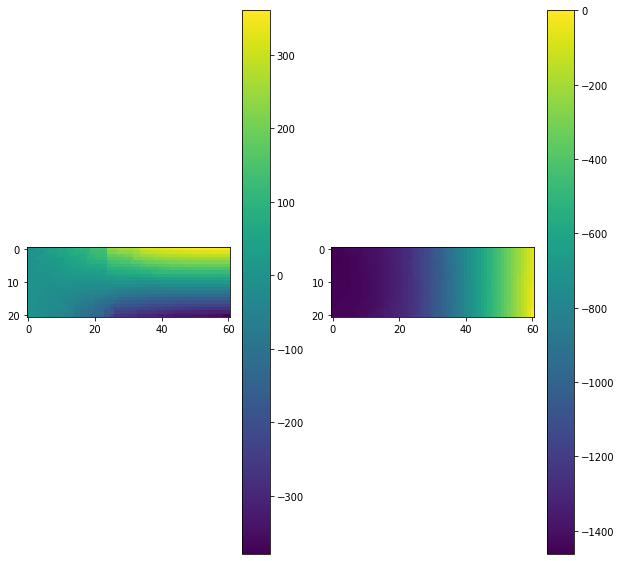

(20, 60)

In [ ]:
def mbb_beam(width=60, height=20, density=0.5):
  """Textbook beam example."""
  normals = np.zeros((width + 1, height + 1, 2))
  normals[-1, -1, Y] = 1
  normals[0, :, X] = 1

  forces = np.zeros((width + 1, height + 1, 2))
  forces[0, 0, Y] = -1

  return Problem(normals, forces, density)

def cantilever_beam_full(
    width=60, height=60, density=0.5, force_position=0):
  """Cantilever supported everywhere on the left."""
  # https://link.springer.com/content/pdf/10.1007%2Fs00158-010-0557-z.pdf
  normals = np.zeros((width + 1, height + 1, 2))
  normals[0, :, :] = 1

  forces = np.zeros((width + 1, height + 1, 2))
  forces[-1, round((1 - force_position)*height), Y] = -1

  return Problem(normals, forces, density)  

densities = np.random.rand(20,60)
problem = cantilever_beam_full(32,32,force_position=0)
problem = mbb_beam(60,20)
params = specified_task(problem)
u, ux, uy= fem_solver(densities, params)
plot_displacement(ux, uy)
c = compliance(densities, ux, uy)
c.shape
# plot_compliance(c)

In [ ]:
def generate_dataset(problem, num):
  dens, disps, sens, uxs, uys = [], [], [], [], []
  params = specified_task(problem)
  nelx, nely = params['nelx'], params['nely']
  for i in range(num):
    den = np.random.rand(nely,nelx) + 1e-09
    u, ux, uy = fem_solver(den, params)
    sen = compliance(den, ux, uy)
    uxs.append(ux)
    uys.append(uy)
    dens.append(den)
    disps.append(u)
    sens.append(sen)
  ds = xr.Dataset({
        'dens': (('number', 'nely', 'nelx'), dens),
        'uxs': (('number', 'nnpy', 'nnpx'), uxs),
        'uys': (('number', 'nnpy', 'nnpx'), uys),
        'disps': (('number', 'dofs'), disps),
        'sens': (('number', 'nely', 'nelx'), sens)
    }, coords={'number': np.arange(len(dens))})
  return ds

In [ ]:
problem = cantilever_beam_full(60,20,force_position=0)
%time ds = generate_dataset(problem, num=10000)
ds.to_netcdf("/content/drive/MyDrive/Data/canti_fpos0_10000.nc")

CPU times: user 4min 21s, sys: 7.38 s, total: 4min 29s
Wall time: 4min 29s
